In [1]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed

import warnings

In [2]:
# settings
plt.rcParams['figure.figsize'] = (15, 4)
sns.set()
warnings.filterwarnings('ignore')

In [3]:
url = 'https://raw.githubusercontent.com/bartk97/Anomaly-Detection/main/Data/META.csv'

df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')



print('data size: ', df.shape)
print('missing value: ', df.isnull().to_numpy().sum())

df = df[['Close']]

df.head()

data size:  (2536, 6)
missing value:  0


,Close
Date,
2012-05-18,38.230000
2012-05-21,34.029999
2012-05-22,31.000000
2012-05-23,32.000000
2012-05-24,33.029999


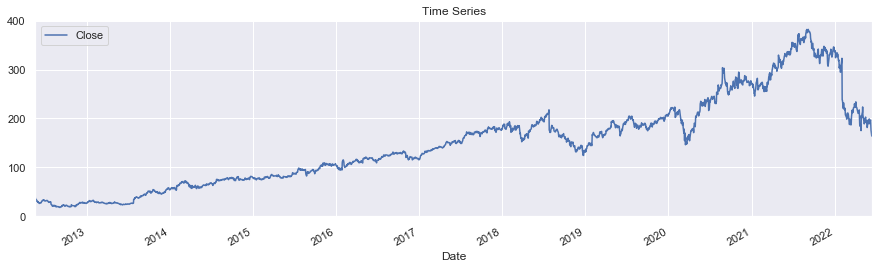

In [4]:
df.plot(title='Time Series')
plt.show()

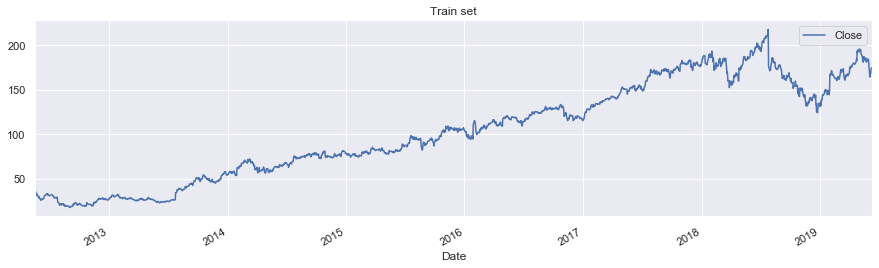

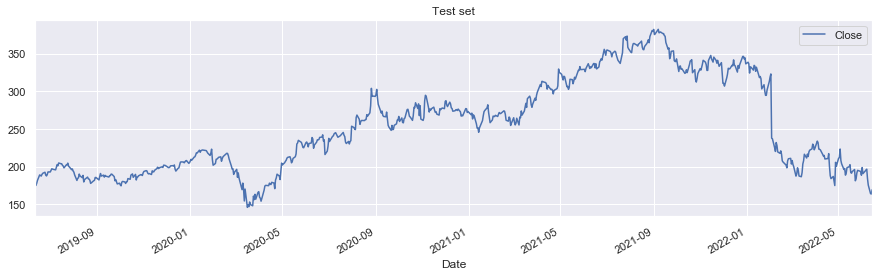

In [5]:
train_size = 0.7
n_train = int(df.shape[0] * train_size)

df_train = df[:n_train]
df_test = df[n_train:]

df_train.plot(title='Train set')
plt.show()

df_test.plot(title='Test set')
plt.show()

In [6]:
scaler = StandardScaler()
scaler = scaler.fit(df_train[['Close']])

df_train['Close'] = scaler.transform(df_train[['Close']])
df_test['Close'] = scaler.transform(df_test[['Close']])

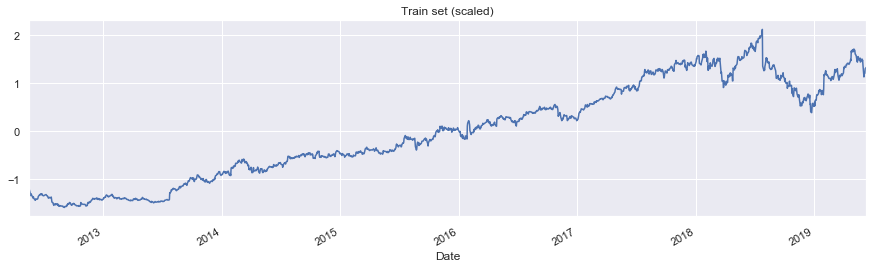

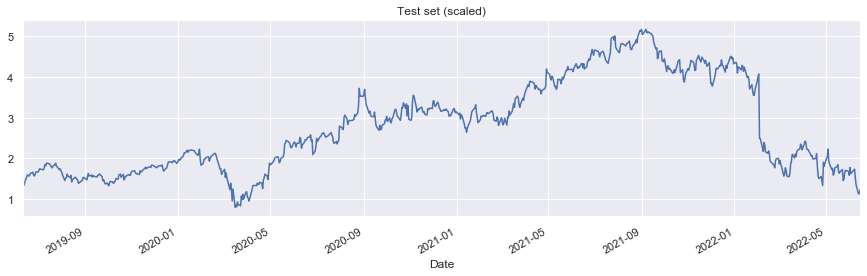

In [7]:
df_train['Close'].plot(title='Train set (scaled)')
plt.show()

df_test['Close'].plot(title='Test set (scaled)')
plt.show()

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 30

X_train, y_train = create_dataset(df_train[['Close']], df_train.Close, time_steps)
X_test, y_test = create_dataset(df_test[['Close']], df_test.Close, time_steps)

print(X_train.shape)

(1745, 30, 1)


In [10]:
model = Sequential([
    LSTM(128, input_shape=(time_steps, 1)),
    Dropout(0.2),
    RepeatVector(time_steps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(1))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [11]:
epochs = 100
batch_size = 32
validation_split = 0.1
shuffle = False
callbacks = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)


history = model.fit(X_train, y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_split = validation_split,
                    callbacks = [callbacks],
                    shuffle = shuffle)

Train on 1570 samples, validate on 175 samples
Epoch 1/100
1570/1570 [==============================] - 16s 10ms/sample - loss: 0.2329 - val_loss: 0.1699
Epoch 2/100
1570/1570 [==============================] - 10s 7ms/sample - loss: 0.1891 - val_loss: 0.1305
Epoch 3/100
1570/1570 [==============================] - 8s 5ms/sample - loss: 0.1024 - val_loss: 0.0997
Epoch 4/100
1570/1570 [==============================] - 8s 5ms/sample - loss: 0.1263 - val_loss: 0.0982
Epoch 5/100
1570/1570 [==============================] - 8s 5ms/sample - loss: 0.0830 - val_loss: 0.0825
Epoch 6/100
1570/1570 [==============================] - 8s 5ms/sample - loss: 0.1201 - val_loss: 0.0995
Epoch 7/100
1570/1570 [==============================] - 8s 5ms/sample - loss: 0.1068 - val_loss: 0.0804
Epoch 8/100
1570/1570 [==============================] - 8s 5ms/sample - loss: 0.1213 - val_loss: 0.1181
Epoch 9/100
1570/1570 [==============================] - 8s 5ms/sample - loss: 0.1301 - val_loss: 0.0789
Epoch

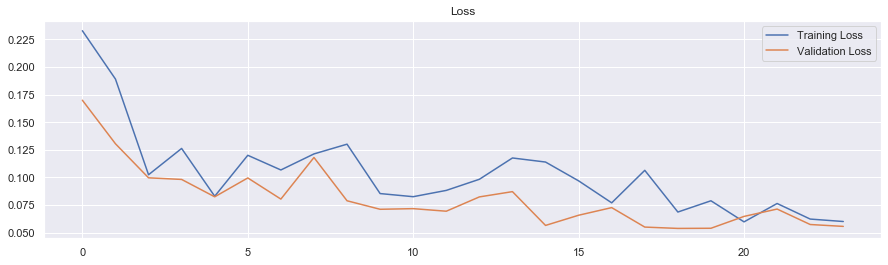

In [12]:
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [13]:
model.evaluate(X_test, y_test)

731/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.2262903445804168

In [14]:
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

mae = lambda x_pred, x: np.mean(np.abs(x_pred - x), axis=1)

train_mae_loss = mae(X_train_pred, X_train)
test_mae_loss = mae(X_test_pred, X_test)

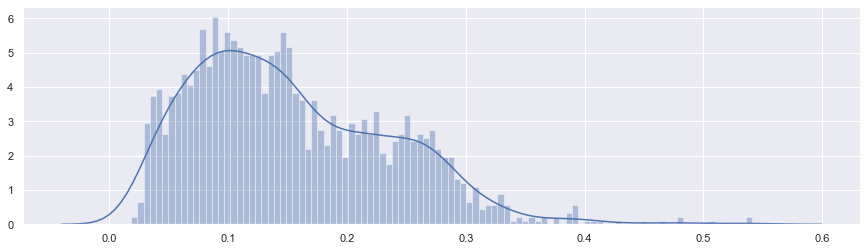

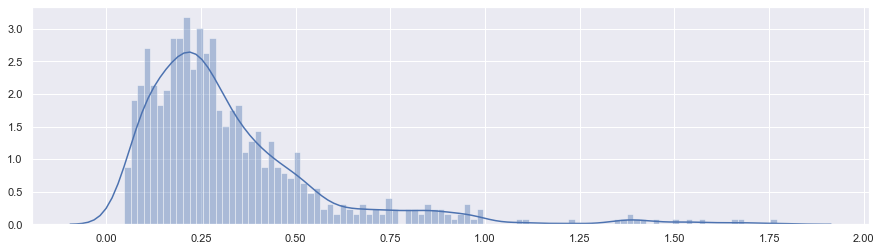

In [15]:
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.show()

sns.distplot(test_mae_loss, bins=100, kde=True)
plt.show()

In [16]:
q = np.quantile(test_mae_loss, 0.9)
print(q)

0.6236796190923356


In [17]:
threshold = q
#threshold = 0.4

test_score_df = pd.DataFrame(df_test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = df_test[time_steps:].Close

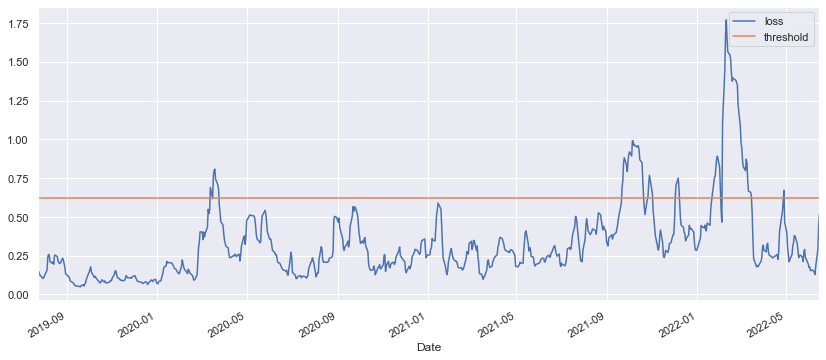

In [18]:
test_score_df[['loss', 'threshold']].plot(figsize=(14, 6))
plt.show()

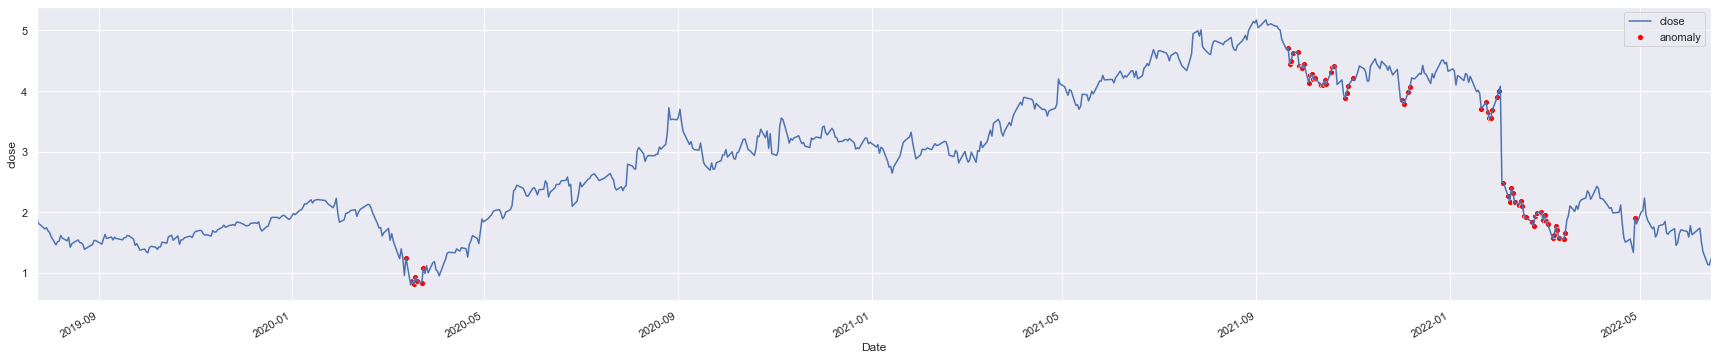

In [19]:
anomalies = test_score_df[test_score_df['anomaly'] == 1]
test_score_df[['close']].plot(figsize=(30, 6))
sns.scatterplot(anomalies.index, anomalies['close'],label='anomaly',color='red')
plt.show()